<a href="https://colab.research.google.com/github/3791xk/invasive-plants-ml/blob/main/Another_copy_of_LeafDamageConvNext_with_crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

80-10-10 split

Load Dataset for hawaii invasive species dataset

In [ ]:
import os
import time
from tempfile import TemporaryDirectory
from PIL import Image
import pandas as pd
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import random

Yolo Set up, crop images preprocessing

In [ ]:
!pip install ultralytics huggingface_hub opencv-python -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [ ]:
# yolo setup
USE_YOLO = True
YOLO_CONF_THRESHOLD = 0.55
YOLO_MIN_GREEN = 0.0
YOLO_PAD_RATIO = 0.05

if USE_YOLO:
    import cv2
    from ultralytics import YOLO
    from huggingface_hub import hf_hub_download

    print("\n[YOLO] Downloading model from Hugging Face...")

    try:
        # Download the model
        model_path = hf_hub_download(
            repo_id="pedromiguelsanchez/yolo-plant-leaf-detection",
            filename="yolo11x_leaf.pt"
        )
        print(f"[YOLO] Model downloaded to: {model_path}")

        yolo_model = YOLO(model_path)

        # cache: path string -> (x1p, y1p, x2p, y2p)
        crop_cache = {}

        def green_fraction(pil_img: Image.Image) -> float:
            """Compute fraction of 'green' pixels in a PIL RGB image using HSV thresholding."""
            arr = np.array(pil_img.convert("RGB"))
            hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)

            lower_green = np.array([35, 40, 40])
            upper_green = np.array([85, 255, 255])

            mask = cv2.inRange(hsv, lower_green, upper_green)
            if mask.size == 0:
                return 0.0

            green_pixels = mask > 0
            return float(green_pixels.mean())

        def crop_with_yolo_most_green(pil_img: Image.Image, cache_key: str | None = None) -> Image.Image:
            """Run YOLO once per image (cached by path), crop to most-green box, else return original."""
            if cache_key is not None and cache_key in crop_cache:
                x1p, y1p, x2p, y2p = crop_cache[cache_key]
                return pil_img.crop((x1p, y1p, x2p, y2p))

            w, h = pil_img.size
            results = yolo_model(pil_img, verbose=False)
            if len(results) == 0 or results[0].boxes is None or len(results[0].boxes) == 0:
                return pil_img

            boxes = results[0].boxes
            best_crop = None
            best_green = -1.0
            best_coords = None

            for box in boxes:
                xyxy = box.xyxy[0].cpu().numpy()
                conf = float(box.conf.cpu().item())
                if conf < YOLO_CONF_THRESHOLD:
                    continue

                x1, y1, x2, y2 = map(int, xyxy)
                bw = x2 - x1
                bh = y2 - y1
                pad_w = int(bw * YOLO_PAD_RATIO)
                pad_h = int(bh * YOLO_PAD_RATIO)

                x1p = max(0, x1 - pad_w)
                y1p = max(0, y1 - pad_h)
                x2p = min(w, x2 + pad_w)
                y2p = min(h, y2 + pad_h)

                crop = pil_img.crop((x1p, y1p, x2p, y2p))
                gf = green_fraction(crop)

                if gf >= YOLO_MIN_GREEN and gf > best_green:
                    best_green = gf
                    best_crop = crop
                    best_coords = (x1p, y1p, x2p, y2p)

            if best_crop is None:
                return pil_img

            if cache_key is not None:
                crop_cache[cache_key] = best_coords
            return best_crop

        print("[YOLO] Model loaded successfully!")

    except Exception as e:
        print(f"[YOLO] Error loading model: {e}")
        print("[YOLO] Disabling YOLO, using original images")
        USE_YOLO = False
        def crop_with_yolo_most_green(pil_img: Image.Image, cache_key: str | None = None) -> Image.Image:
            """Identity function when YOLO is disabled."""
            return pil_img

else:
    def crop_with_yolo_most_green(pil_img: Image.Image, cache_key: str | None = None) -> Image.Image:
        """Identity function when YOLO is disabled."""
        return pil_img

print("USE_YOLO =", USE_YOLO)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

[YOLO] Downloading model from Hugging Face...


yolo11x_leaf.pt:   0%|          | 0.00/114M [00:00<?, ?B/s]

[YOLO] Model downloaded to: /root/.cache/huggingface/hub/models--pedromiguelsanchez--yolo-plant-leaf-detection/snapshots/ccd390f303a32c8063ae54c09c1ac3b9ee158dea/yolo11x_leaf.pt
[YOLO] Model loaded successfully!
USE_YOLO = True


In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("imageomics/invasive_plants_hawaii", name="full", split="both")

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

full/dorsal-00000-of-00024.parquet:   0%|          | 0.00/819M [00:00<?, ?B/s]

full/dorsal-00001-of-00024.parquet:   0%|          | 0.00/693M [00:00<?, ?B/s]

full/dorsal-00002-of-00024.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

full/dorsal-00003-of-00024.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

full/dorsal-00004-of-00024.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

full/dorsal-00005-of-00024.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

full/dorsal-00006-of-00024.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

full/dorsal-00007-of-00024.parquet:   0%|          | 0.00/548M [00:00<?, ?B/s]

full/dorsal-00008-of-00024.parquet:   0%|          | 0.00/544M [00:00<?, ?B/s]

full/dorsal-00009-of-00024.parquet:   0%|          | 0.00/368M [00:00<?, ?B/s]

full/dorsal-00010-of-00024.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

full/dorsal-00011-of-00024.parquet:   0%|          | 0.00/361M [00:00<?, ?B/s]

full/dorsal-00012-of-00024.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

full/dorsal-00013-of-00024.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

full/dorsal-00014-of-00024.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

full/dorsal-00015-of-00024.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

full/dorsal-00016-of-00024.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

full/dorsal-00017-of-00024.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

full/dorsal-00018-of-00024.parquet:   0%|          | 0.00/382M [00:00<?, ?B/s]

full/dorsal-00019-of-00024.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

full/dorsal-00020-of-00024.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

full/dorsal-00021-of-00024.parquet:   0%|          | 0.00/549M [00:00<?, ?B/s]

full/dorsal-00022-of-00024.parquet:   0%|          | 0.00/543M [00:00<?, ?B/s]

full/dorsal-00023-of-00024.parquet:   0%|          | 0.00/561M [00:00<?, ?B/s]

full/ventral-00000-of-00023.parquet:   0%|          | 0.00/850M [00:00<?, ?B/s]

full/ventral-00001-of-00023.parquet:   0%|          | 0.00/703M [00:00<?, ?B/s]

full/ventral-00002-of-00023.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

full/ventral-00003-of-00023.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

full/ventral-00004-of-00023.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

full/ventral-00005-of-00023.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

full/ventral-00006-of-00023.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

full/ventral-00007-of-00023.parquet:   0%|          | 0.00/579M [00:00<?, ?B/s]

full/ventral-00008-of-00023.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

full/ventral-00009-of-00023.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

full/ventral-00010-of-00023.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

full/ventral-00011-of-00023.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

full/ventral-00012-of-00023.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

full/ventral-00013-of-00023.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

full/ventral-00014-of-00023.parquet:   0%|          | 0.00/523M [00:00<?, ?B/s]

full/ventral-00015-of-00023.parquet:   0%|          | 0.00/322M [00:00<?, ?B/s]

full/ventral-00016-of-00023.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

full/ventral-00017-of-00023.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

full/ventral-00018-of-00023.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

full/ventral-00019-of-00023.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

full/ventral-00020-of-00023.parquet:   0%|          | 0.00/567M [00:00<?, ?B/s]

full/ventral-00021-of-00023.parquet:   0%|          | 0.00/559M [00:00<?, ?B/s]

full/ventral-00022-of-00023.parquet:   0%|          | 0.00/578M [00:00<?, ?B/s]

full/both-00000-of-00046.parquet:   0%|          | 0.00/845M [00:00<?, ?B/s]

full/both-00001-of-00046.parquet:   0%|          | 0.00/846M [00:00<?, ?B/s]

full/both-00002-of-00046.parquet:   0%|          | 0.00/849M [00:00<?, ?B/s]

full/both-00003-of-00046.parquet:   0%|          | 0.00/551M [00:00<?, ?B/s]

full/both-00004-of-00046.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

full/both-00005-of-00046.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

full/both-00006-of-00046.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

full/both-00007-of-00046.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

full/both-00008-of-00046.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

full/both-00009-of-00046.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

full/both-00010-of-00046.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

full/both-00011-of-00046.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

full/both-00012-of-00046.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

full/both-00013-of-00046.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

full/both-00014-of-00046.parquet:   0%|          | 0.00/579M [00:00<?, ?B/s]

full/both-00015-of-00046.parquet:   0%|          | 0.00/579M [00:00<?, ?B/s]

full/both-00016-of-00046.parquet:   0%|          | 0.00/582M [00:00<?, ?B/s]

full/both-00017-of-00046.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

full/both-00018-of-00046.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

full/both-00019-of-00046.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

full/both-00020-of-00046.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

full/both-00021-of-00046.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

full/both-00022-of-00046.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

full/both-00023-of-00046.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

full/both-00024-of-00046.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

full/both-00025-of-00046.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

full/both-00026-of-00046.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

full/both-00027-of-00046.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

full/both-00028-of-00046.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

full/both-00029-of-00046.parquet:   0%|          | 0.00/594M [00:00<?, ?B/s]

full/both-00030-of-00046.parquet:   0%|          | 0.00/325M [00:00<?, ?B/s]

full/both-00031-of-00046.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

full/both-00032-of-00046.parquet:   0%|          | 0.00/336M [00:00<?, ?B/s]

full/both-00033-of-00046.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

full/both-00034-of-00046.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

full/both-00035-of-00046.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

full/both-00036-of-00046.parquet:   0%|          | 0.00/398M [00:00<?, ?B/s]

full/both-00037-of-00046.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

full/both-00038-of-00046.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

full/both-00039-of-00046.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

full/both-00040-of-00046.parquet:   0%|          | 0.00/574M [00:00<?, ?B/s]

full/both-00041-of-00046.parquet:   0%|          | 0.00/558M [00:00<?, ?B/s]

full/both-00042-of-00046.parquet:   0%|          | 0.00/552M [00:00<?, ?B/s]

full/both-00043-of-00046.parquet:   0%|          | 0.00/568M [00:00<?, ?B/s]

full/both-00044-of-00046.parquet:   0%|          | 0.00/582M [00:00<?, ?B/s]

full/both-00045-of-00046.parquet:   0%|          | 0.00/574M [00:00<?, ?B/s]

Generating dorsal split:   0%|          | 0/821 [00:00<?, ? examples/s]

Generating ventral split:   0%|          | 0/821 [00:00<?, ? examples/s]

Generating both split:   0%|          | 0/1642 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
cols = ['healthy', 'leaf_miner', 'rust', 'other_insect', 'mechanical_damage']

# load dataset into pandas df
leaf_df = ds.to_pandas()
leaf_df.replace('nan', np.nan, inplace=True)

# Create a version with 0 and 1 for "No" and "Yes"
bool_df = leaf_df.replace(to_replace = ['Yes','No', 'Maybe'],value = ['1','0','0.5'])
bool_df.head()

,session,filename,sampling_type,image,site,day,plant,level,view,healthy,...,mechanical_damage,other_remarks,expert_healthy,expert_rust,expert_leaf_miner,expert_other_insect,expert_mechanical_damage,expert_confidence,expert_other_remarks,expert_notes
0,session_1_1_16_2025,DSC00752.png,opportunistic,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,16,exp,NaN,D,0,...,0,NaN,0,1,0,0,0,Clear,NaN,spots
1,session_1_1_16_2025,DSC00753.png,opportunistic,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,16,exp,NaN,V,0,...,0,NaN,0,1,0,0,0,Clear,NaN,spots
2,session_1_1_16_2025,DSC00675.png,opportunistic,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,16,exp,NaN,D,0,...,0,NaN,0,1,0,0,0,Clear,NaN,NaN
3,session_1_1_16_2025,DSC00676.png,opportunistic,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,16,exp,NaN,V,0,...,0,NaN,0,1,0,0,0,Clear,NaN,NaN
4,session_1_1_16_2025,DSC00687.png,opportunistic,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,16,exp,NaN,D,0,...,0,NaN,0,1,0,0,0,0.5,NaN,NaN


ConvNext

make list of images and their labels and split into train/validation/test (80/10/10)

In [ ]:
data = []
for idx, row in bool_df.iterrows():
    # Make sure labels are numbers, not strings
    labels = []
    for col in cols:
        val = row[col]
        if pd.isna(val):
            labels.append(0.0)
        else:
            labels.append(float(val))

    data.append({'image': row['image'], 'labels': labels})

#shuffle images
random.seed(43)
random.shuffle(data)

# Then split
n = len(data)
train_data = data[:int(0.8*n)]
val_data = data[int(0.8*n):int(0.9*n)]
test_data = data[int(0.9*n):]

Custom Dataset Class for pytorch

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = item['image']

        # If it's a dict with bytes, load from bytes
        if isinstance(img, dict) and 'bytes' in img:
            from io import BytesIO
            img = Image.open(BytesIO(img['bytes']))
        elif not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        img = img.convert('RGB')
        img = crop_with_yolo_most_green(img, cache_key=str(idx))
        labels = torch.tensor(item['labels'], dtype=torch.float32)
        return self.transform(img), labels

dataloaders and setup of model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_loader = DataLoader(PlantDataset(train_data, transform), batch_size=32, shuffle=True)
val_loader = DataLoader(PlantDataset(val_data, transform), batch_size=32)
test_loader = DataLoader(PlantDataset(test_data, transform), batch_size=32)

#setup Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.convnext_tiny(pretrained=True)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(cols))
model = model.to(device)

lossFn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train convnext

In [ ]:
passThroughs = 10
history = {'train': [], 'val': []}

for pass_num in range(passThroughs):
    print(f"\n{'='*50}")
    print(f"Pass {pass_num+1}/{passThroughs}")
    print(f"{'='*50}")

    # Train
    model.train()
    train_loss = 0
    print("Training...")
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = lossFn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Print every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Validate
    model.eval()
    val_loss = 0
    print("Validating...")
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += lossFn(outputs, labels).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"  Pass {pass_num+1} Complete:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")

print("\n Training finished")


Pass 1/10
Training...
  Batch 10/42 - Loss: 0.5792
  Batch 20/42 - Loss: 0.5433
  Batch 30/42 - Loss: 0.4452
  Batch 40/42 - Loss: 0.3669
Validating...
  Pass 1 Complete:
  Train Loss: 0.5044
  Val Loss: 0.5909

Pass 2/10
Training...
  Batch 10/42 - Loss: 0.4240
  Batch 20/42 - Loss: 0.3205
  Batch 30/42 - Loss: 0.3240
  Batch 40/42 - Loss: 0.3027
Validating...
  Pass 2 Complete:
  Train Loss: 0.3778
  Val Loss: 0.4939

Pass 3/10
Training...
  Batch 10/42 - Loss: 0.3712
  Batch 20/42 - Loss: 0.3702
  Batch 30/42 - Loss: 0.3365
  Batch 40/42 - Loss: 0.2947
Validating...
  Pass 3 Complete:
  Train Loss: 0.3109
  Val Loss: 0.5012

Pass 4/10
Training...
  Batch 10/42 - Loss: 0.2177
  Batch 20/42 - Loss: 0.2439
  Batch 30/42 - Loss: 0.2368
  Batch 40/42 - Loss: 0.3186
Validating...
  Pass 4 Complete:
  Train Loss: 0.2749
  Val Loss: 0.5193

Pass 5/10
Training...
  Batch 10/42 - Loss: 0.2640
  Batch 20/42 - Loss: 0.2254
  Batch 30/42 - Loss: 0.1697
  Batch 40/42 - Loss: 0.2174
Validating...

Testing and Results


Test Accuracy:
healthy: 82.42%
leaf_miner: 85.45%
rust: 61.21%
other_insect: 80.61%
mechanical_damage: 69.70%


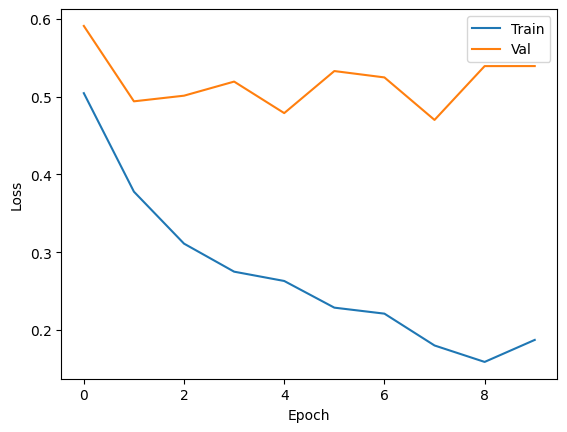

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print("\nTest Accuracy:")
for i, name in enumerate(cols):
    acc = (all_preds[:, i] == all_labels[:, i]).mean()
    print(f"{name}: {acc:.2%}")

# Plot
plt.plot(history['train'], label='Train')
plt.plot(history['val'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()



Test Results:
Class                Accuracy     F1 Score    
healthy              79.27%          0.4333
leaf_miner           82.32%          0.5246
rust                 65.75%          0.6753
other_insect         79.49%          0.6190
mechanical_damage    67.53%          0.3750
Overall F1 (macro)   0.5255


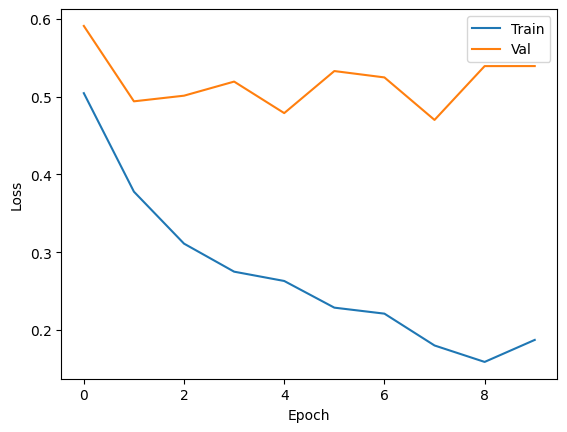


Done!


In [ ]:
from sklearn.metrics import f1_score

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.35).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print("\nTest Results:")
print(f"{'Class':<20} {'Accuracy':<12} {'F1 Score':<12}")
print("="*44)

f1_scores = []
for i, name in enumerate(cols):
    # Remove samples where label is 0.5 (Maybe)
    mask = all_labels[:, i] != 0.5
    labels_filtered = all_labels[mask, i]
    preds_filtered = all_preds[mask, i]

    if len(labels_filtered) > 0:
        acc = (preds_filtered == labels_filtered).mean()
        f1 = f1_score(labels_filtered, preds_filtered, average='binary')
        f1_scores.append(f1)
        print(f"{name:<20} {acc:.2%}          {f1:.4f}")
    else:
        print(f"{name:<20} No clear labels")

# Overall F1
overall_f1 = np.mean(f1_scores)
print("="*44)
print(f"{'Overall F1 (macro)':<20} {overall_f1:.4f}")

# Plot
plt.plot(history['train'], label='Train')
plt.plot(history['val'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

print("\nDone!")

In [ ]:
from sklearn.metrics import roc_auc_score
roc_aucs = {}

for i, name in enumerate(cols):
    # Convert labels to int
    labels_int = all_labels[:, i].astype(int)
    preds_prob = all_preds[:, i]

    # Skip if only one class present
    if len(np.unique(labels_int)) < 2:
        continue

    auc = roc_auc_score(labels_int, preds_prob)
    roc_aucs[name] = auc
    print(f"{name}: ROC-AUC = {auc:.4f}")

# Macro ROC-AUC
if len(roc_aucs) > 0:
    macro_auc = np.mean(list(roc_aucs.values()))
    print(f"Macro ROC-AUC (valid classes only): {macro_auc:.4f}")
else:
    print("No valid classes to compute ROC-AUC")


healthy: ROC-AUC = 0.6402
leaf_miner: ROC-AUC = 0.7074
rust: ROC-AUC = 0.6476
other_insect: ROC-AUC = 0.7637
mechanical_damage: ROC-AUC = 0.6184
Macro ROC-AUC (valid classes only): 0.6755
